# Day 2: LangChain vs. LangGraph - The Self-Correcting AI Researcher

**Objective:** To understand the practical differences between a standard `AgentExecutor` and `LangGraph` for building complex, stateful AI agents.

In this notebook, we will attempt to build an agent with a crucial capability: **self-correction**. The agent's task is to research a topic, but with a twist. It must:
1. Perform an initial web search.
2. **Analyze** its own search results to see if they are good enough.
3. If the results are poor, it must **rewrite** its search query and try again.
4. Only when it has sufficient information should it provide a final answer.

This cyclical, self-evaluating behavior is a hallmark of more advanced, reliable agents. We will see how a standard agent struggles with this task and how LangGraph is explicitly designed to solve it.

## 1. Setup and Dependencies

First, let's install the necessary libraries. We will use `ddgs` for DuckDuckGo search as the older package is deprecated. Then we'll import our modules and set up the environment. Make sure you have a `.env` file in the same directory with your `OPENAI_API_KEY`, or set it up as a secret in your Colab environment.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install -qU langchain langchain-openai langgraph langchain_community ddgs python-dotenv

In [ ]:
!pip install -U duckduckgo-search

In [ ]:
import os
from dotenv import load_dotenv

# Load the API key from the .env file
load_dotenv("dev.env")

print("Dependencies installed and environment loaded.")

Dependencies installed and environment loaded.


---

## Part 1: The LangChain Agent Attempt (The Brittle Approach)

Here, we'll try to force a standard `AgentExecutor` to perform the self-correction loop by cramming all the logic into a complex prompt. We are essentially *telling* the agent to follow our steps, but we cannot *enforce* it.

**Hypothesis:** The agent will likely struggle to follow the cyclical instructions. It is heavily biased towards moving forward to a `Final Answer` and may ignore the command to loop back, especially if the initial results are weak.

### 1.1: Define Tools and LLM

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun

# Tool: The agent only has one tool, a web search.
search_tool = DuckDuckGoSearchRun()
tools = [search_tool]

# LLM: Using a powerful model to give it the best chance.
llm = ChatOpenAI(model="gpt-4o", temperature=0)

### 1.2: The Complex Prompt

This is the core of the attempt. We modify a standard ReAct prompt to include a detailed, multi-step procedure. The agent's ability to follow these instructions is entirely dependent on the LLM's interpretation, making it unreliable.

In [ ]:
from langchain import hub

# Pull a base ReAct prompt
prompt_template = hub.pull("hwchase17/react").copy()

# Manually inject our complex, cyclical instructions
prompt_template.template = """
You are an expert web researcher. Your goal is to provide a comprehensive answer. You MUST follow these steps precisely:

Step 1: Initial Search. Use the search tool with a query based on the user's topic.
Step 2: Critical Analysis. After getting the search results, you MUST pause and analyze them. Ask yourself: 'Are these results detailed enough to write a good answer?'
Step 3: Decision and Self-Correction.
- If the results ARE sufficient, proceed to Step 4.
- If the results ARE NOT sufficient, you MUST formulate a new, more specific search query and go back to Step 1. This is a critical self-correction step.

Step 4: Final Answer. Once you have sufficient information, synthesize it into a final, detailed answer.

You have access to the following tools:
{tools}

Use the following format:
Question: the input question you must answer
Thought: your reasoning and plan for the next action (following the steps above)
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat multiple times)
Thought: I now have enough information to answer the user's question.
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
"""


### 1.3: Create and Run the Agent

Now we assemble the agent and run it. Observe the `verbose` output carefully to see if it follows our instructions. The final output will be rendered as Markdown.

In [ ]:
from langchain.agents import AgentExecutor, create_react_agent
from IPython.display import display, Markdown

# Create the Agent
agent_v1 = create_react_agent(llm, tools, prompt_template)
agent_executor_v1 = AgentExecutor(agent=agent_v1, tools=tools, verbose=True, handle_parsing_errors=True)

# Let's run it with a niche topic that likely requires re-searching
topic = "The impact of LangGraph on multi-agent system reliability compared to traditional agent loops"
topic = "What is LangGraph"
response_v1 = agent_executor_v1.invoke({"input": topic})

# Render the final output as Markdown
print("\n--- Agent's Final Answer (Formatted as Markdown) ---")
display(Markdown(response_v1['output']))



> Entering new AgentExecutor chain...
To provide a comprehensive answer about "LangGraph," I will start by conducting an initial search to gather information on this topic.

Action: duckduckgo_search
Action Input: "LangGraph"


/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Jun 17, 2025 · Explore how LangGraph, the graph-based agent framework from LangChain, empowers developers and organizations to orchestrate complex AI workflows, integrate with any … 6 days ago · This document covers LangGraph's collection of practical examples, tutorials, and templates that demonstrate how to build stateful, multi-actor applications using the framework. … Jul 17, 2025 · LangGraph is a stateful orchestration framework built on top of LangChain. It lets your AI: Why use graphs instead of chains? Graphs mimic real thinking — branching, re-routing, and … Build controllable agents with LangGraph, our low-level agent orchestration framework. Deploy and scale with LangGraph Platform, with APIs for state management, a visual studio for debugging, … LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that …The search results provide a good amoun

LangGraph is a stateful orchestration framework developed by LangChain. It is designed to build, deploy, and manage complex generative AI agent workflows. LangGraph is built on top of LangChain and offers a graph-based approach to AI workflow orchestration, which mimics real thinking by allowing for branching and re-routing. This framework is particularly useful for creating stateful, multi-actor applications and provides tools and libraries to facilitate the development of these applications. LangGraph also includes features for state management, a visual studio for debugging, and APIs to help developers and organizations integrate and scale their AI solutions effectively.

### 1.4: Analysis of the LangChain Agent's Performance

You will likely observe that the agent performs one search and then immediately proceeds to a `Final Answer`, even if the results are clearly insufficient. It fails to follow the instruction to loop back.

**The core problem is the lack of control.** We are *suggesting* a workflow in the prompt, but the `AgentExecutor`'s fundamental design doesn't support enforcing this kind of cycle. This is a classic example of a workflow that is **not feasible** to implement reliably with this architecture.

---

## Part 2: The LangGraph Solution (The Robust Approach)

Now, let's build the same agent using LangGraph. Instead of a complex prompt, we will define our workflow as an explicit graph of nodes and edges.

**Hypothesis:** The LangGraph implementation will reliably execute the self-correction loop every time it's needed, because the flow is enforced by code, not suggested by a prompt.

### 2.1: Define the State

The `State` is a central concept in LangGraph. It's a single object (in this case, a dictionary) that gets passed between all the nodes in our graph. Each node can read from it and write to it, allowing us to track our progress through the workflow.

In [ ]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """Represents the state of our research agent."""
    topic: str
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]
    search_results: str | None
    retries: int

### 2.2: Define the Graph Nodes

Nodes are the fundamental building blocks of a LangGraph workflow. Each node is a simple Python function that receives the current `state` and returns a dictionary containing the values to update in the state.

#### Node 1: `initial_search_node`
This node performs the first web search based on the initial topic and initializes our retry counter.

In [ ]:
def initial_search_node(state: AgentState):
    print("---NODE: Initial Search---")
    search_results = search_tool.run(state['topic'])
    return {"search_results": search_results, "retries": 0}

#### Node 2: `analyze_results_node` (Improved Logic)

This node uses the LLM to act as a judge. **This is the improved version.** It now explicitly checks if the search tool failed. If so, it immediately decides the results are `insufficient`, making the agent more robust.

In [ ]:
from langchain_core.messages import SystemMessage

def analyze_results_node(state: AgentState):
    print("---NODE: Analyze Results---")
    search_results = state['search_results']

    # Check for a failed search result explicitly.
    if not search_results or "No good DuckDuckGo Search Result was found" in search_results:
        print("Analysis Decision: Search failed, results are insufficient.")
        return {"messages": [SystemMessage(content="Analysis: insufficient")]}

    analysis_prompt = f"""You are an expert researcher. Analyze these search results for the topic '{state['topic']}' and determine if they are sufficient to write a comprehensive answer. Respond with only 'sufficient' or 'insufficient'.\n\nResults:\n{state['search_results']}"""
    response = llm.invoke(analysis_prompt)
    decision = response.content.strip().lower()
    print(f"Analysis Decision: {decision}")
    return {"messages": [SystemMessage(content=f"Analysis: {decision}")]}

#### Node 3: `rewrite_query_node`

This node is only called if the analysis fails. It uses the LLM to generate a *better* search query and then executes the search again, updating the state with the new results.

In [ ]:
def rewrite_query_node(state: AgentState):
    print("---NODE: Rewrite Query---")
    retries = state['retries']
    rewrite_prompt = f"""You are a search expert. Your search for '{state['topic']}' was insufficient. Rewrite it into a better, more specific search query."""
    new_query = llm.invoke(rewrite_prompt).content.strip()
    print(f"New Query: {new_query}")
    search_results = search_tool.run(new_query)
    return {"search_results": search_results, "retries": retries + 1}

#### Node 4: `final_response_node`

This is the final step, only reached when the results are deemed sufficient. It synthesizes all the gathered information into a comprehensive answer.

In [ ]:
def final_response_node(state: AgentState):
    print("---NODE: Final Response---")
    response_prompt = f"""Based on the following search results, provide a detailed answer to the topic: '{state['topic']}'.\n\nResults:\n{state['search_results']}"""
    final_response = llm.invoke(response_prompt).content
    return {"messages": [SystemMessage(content=final_response)]}

### 2.3: Define the Edges and Assemble the Graph

Edges connect our nodes. A **conditional edge** is a special type of edge that uses a function to decide which node to go to next based on the current state. This is how we create our self-correction loop.

In [ ]:
from langgraph.graph import StateGraph, END

# This function is our conditional edge.
def should_continue_edge(state: AgentState):
    # First, check for the max retries condition to prevent infinite loops
    if state['retries'] > 2:
        print("---DECISION: Max retries reached, ending.---")
        return "end"

    # Check the analysis message in the state
    last_message = state['messages'][-1].content
    if "insufficient" in last_message:
        print("---DECISION: Results are insufficient, rewriting query.---")
        return "rewrite"
    else:
        print("---DECISION: Results are sufficient, generating final response.---")
        return "end"

# Assemble the graph
workflow = StateGraph(AgentState)
workflow.add_node("initial_search", initial_search_node)
workflow.add_node("analyze_results", analyze_results_node)
workflow.add_node("rewrite_query", rewrite_query_node)
workflow.add_node("final_response", final_response_node)

workflow.set_entry_point("initial_search")
workflow.add_edge("initial_search", "analyze_results")
workflow.add_edge("rewrite_query", "analyze_results") # The crucial loop!
workflow.add_conditional_edges(
    "analyze_results",
    should_continue_edge,
    {"rewrite": "rewrite_query", "end": "final_response"} # This dictionary maps the edge function's return value to a node name
)
workflow.add_edge("final_response", END)

app = workflow.compile()
print("Graph compiled successfully!")

Graph compiled successfully!


### 2.4: Visualize the Graph

One of the best features of LangGraph is the ability to visualize your agent's structure. This makes it incredibly easy to understand and debug the flow.

**Note:** This requires `graphviz` and its development libraries to be installed. The command below handles this for Debian-based systems like Google Colab.

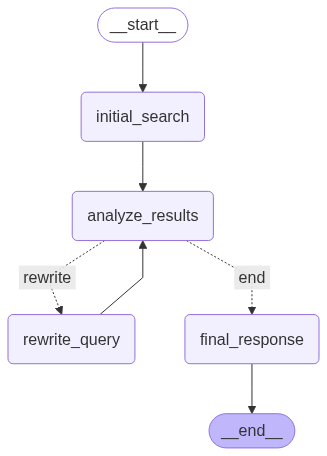

In [ ]:
# Install system dependencies for visualization
!sudo apt-get -qq install -y graphviz libgraphviz-dev
!pip install -q pygraphviz

from IPython.display import Image, display

try:
    # Generate the visualization
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("Please ensure graphviz and its development libraries are installed correctly.")

### 2.5: Run the Graph and Observe the State

Now we run our compiled graph. We will `stream` the events to inspect the **interim state** after each node runs. We also pass a `config` dictionary to set a higher recursion limit, preventing the `GraphRecursionError`.

In [ ]:
initial_input = {"topic": topic, "messages": []}
config = {"recursion_limit": 50} # Set a higher limit for safety

print("--- Running LangGraph App ---")
for i, step in enumerate(app.stream(initial_input, config=config)):
    # The 'step' object contains the output of the node that just ran
    node_name = list(step.keys())[0]
    node_output = step[node_name]

    print(f"\n--- STEP {i+1}: Executed Node '{node_name}' ---")
    print("Output of this node:")
    print(node_output)
    print("-" * 60)

# Get the final state to print the answer
final_state = app.invoke(initial_input, config=config)

print("\n" + "="*50)
print("          LANGGRAPH FINAL ANSWER")
print("="*50)
display(Markdown(final_state['messages'][-1].content))

--- Running LangGraph App ---
---NODE: Initial Search---


/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:



--- STEP 1: Executed Node 'initial_search' ---
Output of this node:
{'search_results': 'Nov 25, 2024 · If you’re curious about creating a powerful chatbot using LangGraph, this guide walks you through everything step by step. Whether you’re a developer looking to enhance your … Feb 16, 2025 · LangGraph is a framework that brings state machines to Large Language Model (LLM) applications. Learn the basics, real examples, and deployment of LangGraph for building … Jun 17, 2025 · LangGraph turns the idea of an AI agent into a scalable system — letting developers coordinate multiple agents or tool calls within a governed workflow. At its core, LangGraph lets … May 20, 2025 · LangGraph is a powerful library, which is a part of LangChain tools. It helps streamline the integration of LLMs, ensuring they work together seamlessly to understand and … Jun 3, 2025 · LangGraph is an open-source framework built on top of LangChain, designed specifically for constructing stateful, multi-agent, and gr

/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Analysis Decision: sufficient
---DECISION: Results are sufficient, generating final response.---
---NODE: Final Response---

          LANGGRAPH FINAL ANSWER


LangGraph is an open-source AI agent framework developed by LangChain, designed to facilitate the building, deployment, and management of AI applications such as chatbots and other AI agents. It is a Python library that provides a robust framework for creating stateful, multi-actor applications, particularly those that leverage large language models.

Key features of LangGraph include:

1. **Stateful Orchestration**: LangGraph is particularly noted for its ability to manage stateful workflows. This means it can maintain the state of an application across different interactions, which is crucial for applications that require context retention over multiple exchanges, such as conversational agents.

2. **Multi-Actor Support**: The framework is designed to handle applications involving multiple actors or components. This is beneficial for complex systems where different parts of the application need to interact with each other in a coordinated manner.

3. **Integration with LangChain Ecosystem**: As part of the LangChain ecosystem, LangGraph is designed to work seamlessly with other tools and libraries within this ecosystem. This integration allows developers to leverage a wide range of functionalities and resources when building their applications.

4. **Control and Flexibility**: LangGraph provides developers with added control over agent workflows, allowing for more precise management of how different components of an application interact and operate. This flexibility is essential for tailoring applications to specific needs and ensuring they function as intended.

Overall, LangGraph is a powerful tool for developers looking to create sophisticated AI applications that require advanced orchestration and state management capabilities. Its integration within the LangChain ecosystem further enhances its utility by providing access to a broader set of tools and resources.

### 2.6: Analysis of the LangGraph Performance

As you can see from the output, the flow is explicit and reliable. The graph moves from node to node, the conditional edge correctly routes the flow back for a retry, and the state is updated predictably at each step. This is the power of defining your agent's logic as code rather than as a prompt.


## Conclusion: The Right Tool for the Job

- **LangChain `AgentExecutor`:** An excellent tool for rapid prototyping and building agents where the workflow is relatively linear (Tool A -> Tool B -> Answer). It's the "automatic transmission" for getting started quickly.

- **LangGraph:** The essential tool for building production-grade, reliable agents that require complex, stateful logic. It provides the "manual transmission" needed for fine-grained control over cycles, retries, and branching, which is impossible to achieve reliably with a standard agent.